In [30]:
%reload_ext autoreload
%autoreload 2
import os, sys
sys.path.append('..')

from tqdm.notebook import tqdm
import pickle

import numpy as np
import healpy as hp
import scipy.interpolate as interpolate
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord

import jax.numpy as jnp
from jax import jit, vmap

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../matplotlibrc')

In [42]:
from utils.units_constants import *
from utils.spectral import *
from utils.nfw import *
from utils.map_utils import *

In [3]:
INTM_DIR = '../data/CHIME_estimate_intermediates'

## 1. Galactic longitude l and latitude b

In [4]:
CHIME_pixel_size = 15 * arcmin # rad

n_b_pix = int(jnp.round(jnp.pi/CHIME_pixel_size))
n_l_pix = int(jnp.round(2*jnp.pi/CHIME_pixel_size))
b_edge_s = jnp.linspace(-jnp.pi/2, jnp.pi/2, n_b_pix+1)
l_edge_s = jnp.linspace(-jnp.pi, jnp.pi, n_l_pix+1)
b_s = (b_edge_s[:-1] + b_edge_s[1:]) / 2 # bin centers
l_s = (l_edge_s[:-1] + l_edge_s[1:]) / 2 # bin centers

l_grid, b_grid = jnp.meshgrid(l_s, b_s)
lb_flat = jnp.stack([l_grid.flatten(), b_grid.flatten()], axis=-1)

## 2. Source (Haslam) map

In [5]:
nu_haslam = 408 # [MHz]
haslam_dsds_map_hp = hp.read_map('../data/haslam_maps/haslam408_dsds_Remazeilles2014.fits')
haslam_dsds_map = hp.pixelfunc.get_interp_val(haslam_dsds_map_hp, l_grid/deg, b_grid/deg, lonlat=True)

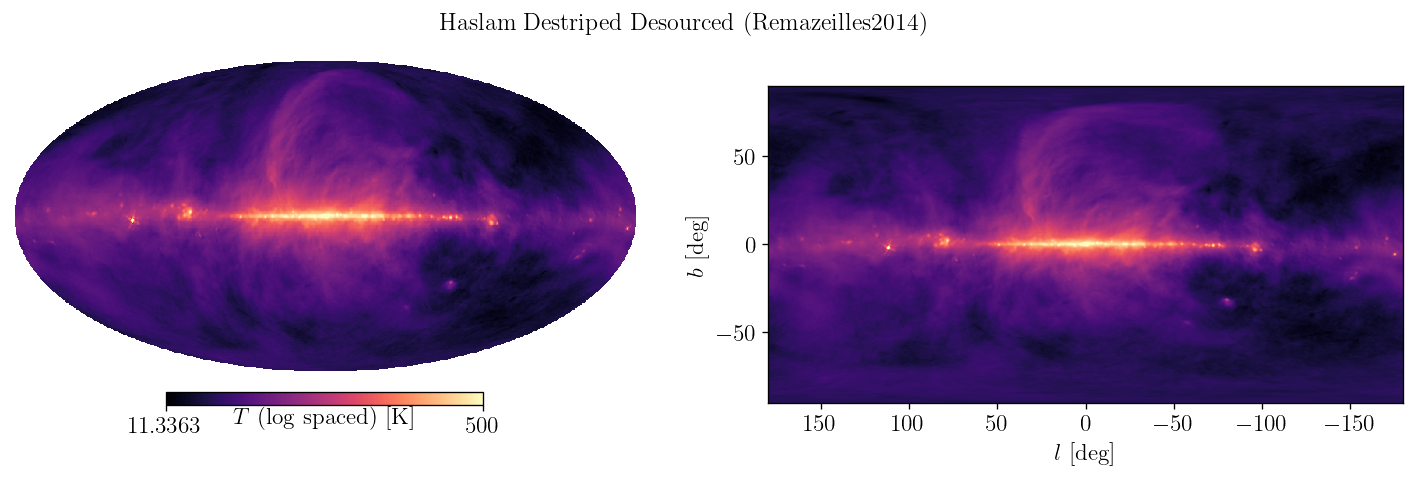

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15,4))

plt.axes(axs[0])
hp.mollview(haslam_dsds_map_hp, norm='log', unit=r'$T$ (log spaced) [K]', title='',
            cmap='magma', max=500, hold=True)
im = axs[1].imshow(np.flip(np.log10(haslam_dsds_map)), cmap='magma', vmax=np.log10(500),
              extent=(180, -180, -90, 90))
axs[1].set(xlabel=r'$l$ [deg]', ylabel=r'$b$ [deg]')
#fig.colorbar(im, ax=axs[1], shrink=0.8)

fig.suptitle('Haslam Destriped Desourced (Remazeilles2014)');

## 2. DM column integral

In [8]:
%%time
rho_integral_map = rho_integral(lb_flat).reshape(n_b_pix, n_l_pix)

CPU times: user 2.31 s, sys: 3.39 s, total: 5.71 s
Wall time: 3 s


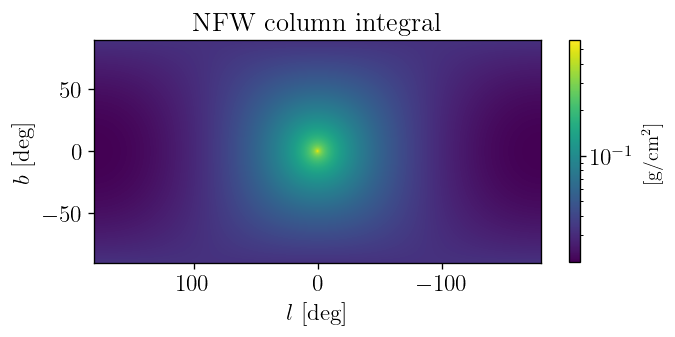

In [9]:
fig, ax = plt.subplots()
im = ax.imshow(jnp.flip(rho_integral_map), extent=(180,-180,-90,90),
               norm=mpl.colors.LogNorm(jnp.min(rho_integral_map), jnp.max(rho_integral_map)))
ax.set(title='NFW column integral', xlabel=r'$l$ [deg]', ylabel=r'$b$ [deg]')
cbar = fig.colorbar(im, ax=ax, shrink=0.6)
cbar.set_label(r'[g/cm$^2$]', fontsize=12);

In [10]:
print(rho_integral_ref, '[g/cm^2]')

0.025303455 [g/cm^2]


## 3. Gegenschein temperature

Gegenschein intensity:
$$I_g=\hbar c^4\frac{g^2}{16}I_{\nu,0}\int\rho.$$
Specific intensity in interested frequency range:
$$I_{\nu,g}=\frac{f_\Delta}{\Delta\nu}\hbar c^4\frac{g^2}{16}I_{\nu,0}\int\rho.$$
Temperature
$$T_g=\frac{f_\Delta}{\Delta\nu}\hbar c^4\frac{g^2}{16}T_0\int\rho=\text{prefac}\cdot T_0\cdot \int\rho.$$
dimensions:
$$\text{[K]}=\frac{[1]}{\text{[MHz]}}\text{[cm}^2\text{ MHz GeV]}(\hbar c^2)\frac{[1]}{\text{[GeV]}^2}\text{[K]}\frac{\text{[GeV]}}{\text{[cm]}^2}(\int\rho c^2).$$

In [12]:
gagg_CAST = 6.6e-11 * invGeV # [cm^-2 MHz^-2 g^-1]
def prefac(nu):
    # prefac ~ [MHz^-1] [cm^2 MHz g] [cm^4 MHz^4] [cm^-4 MHz^-4 g^-2]
    # = [cm^2 g^-1]
    # int rho ~ [g cm^-2]
    # product = [1]
    return (fDelta/dnu(nu)) * hbar * c0**4 * gagg_CAST**2 / 16

In [40]:
# antipodal Haslam map
haslam_anti_dsds_map = antipodal_lb_map(haslam_dsds_map)

# naive (reference) gegenschein temperature
gegen_temp_map = prefac(nu_haslam) * haslam_anti_dsds_map * rho_integral_map

# reference forward+front temperature # I_src * 10kpc uniform column with rho_NFW(r_Sun)
forward_temp_map = prefac(nu_haslam) * haslam_dsds_map * rho_integral_ref

In [14]:
np.save(f'{INTM_DIR}/gegen_temp_map.npy', gegen_temp_map)
np.save(f'{INTM_DIR}/forward_temp_map.npy', forward_temp_map)
np.save(f'{INTM_DIR}/haslam_dsds_map.npy', haslam_dsds_map)

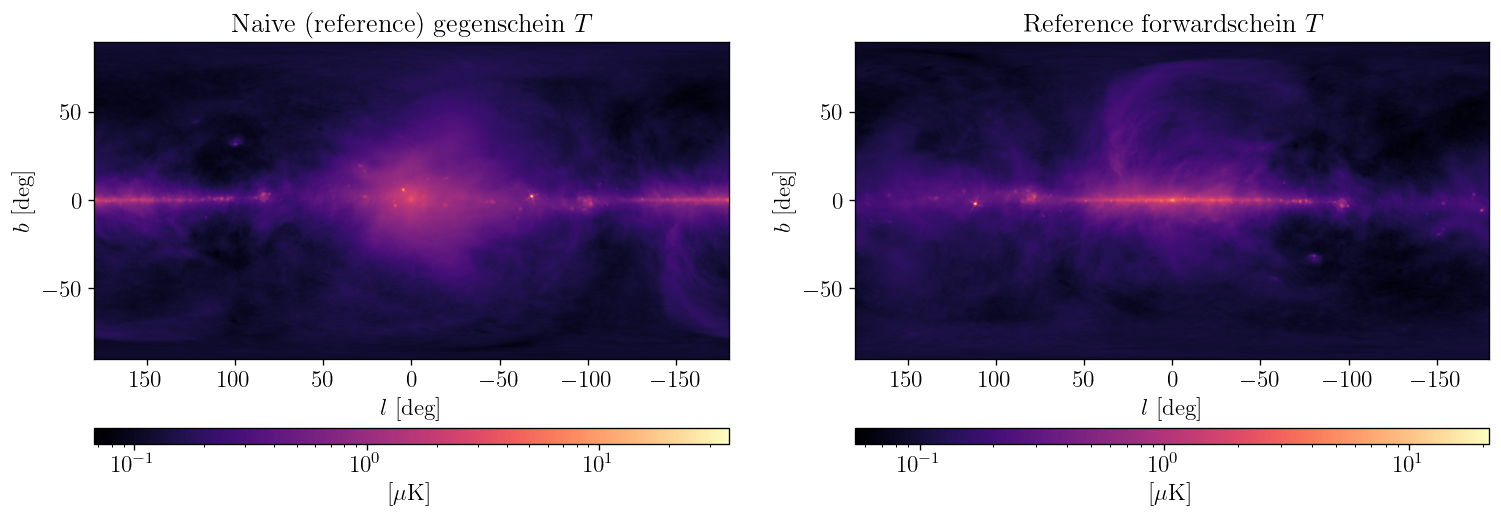

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

z = gegen_temp_map * 1e6
im0 = axs[0].imshow(np.flip(z), cmap='magma', extent=(180, -180, -90, 90),
                    norm=mpl.colors.LogNorm(np.min(z), np.max(z)))
z = forward_temp_map * 1e6
im1 = axs[1].imshow(np.flip(z), cmap='magma', extent=(180, -180, -90, 90),
                    norm=mpl.colors.LogNorm(np.min(z), np.max(z)))
axs[0].set(title=r'Naive (reference) gegenschein $T$', xlabel=r'$l$ [deg]', ylabel=r'$b$ [deg]')
axs[1].set(title=r'Reference forwardschein $T$', xlabel=r'$l$ [deg]', ylabel=r'$b$ [deg]')
cbar0 = fig.colorbar(im0, ax=axs[0], orientation='horizontal', aspect=40)
cbar0.set_label(r'[$\mu$K]')
cbar1 = fig.colorbar(im1, ax=axs[1], orientation='horizontal', aspect=40)
cbar1.set_label(r'[$\mu$K]')

## 4. Exposure

In [17]:
t_baseline = 600 # [s]
double_pass_dec = np.deg2rad(70)

def exposure(dec):
    """Exposure time [s] as a function of dec [rad]. dec can be a vector."""
    return ((dec > double_pass_dec) + 1) * t_baseline / jnp.abs(jnp.cos(dec)) * (dec > jnp.deg2rad(-20))

def icrs_dec(lb):
    """ICRS declination [rad] from galactic lb [(rad, rad)]. Vectorized manually."""
    c_NGP = SkyCoord(l=0*u.deg, b=90*u.deg, frame='galactic') # north galactic pole
    c_NCP = SkyCoord(ra=0*u.deg, dec=90*u.deg, frame='icrs') # north celestial pole
    dec_NGP = float(c_NGP.icrs.dec/u.rad)
    l_NCP = float(c_NCP.galactic.l/u.rad)
    
    l, b = lb[:,0], lb[:,1]
    return jnp.arcsin(jnp.sin(dec_NGP)*jnp.sin(b) + jnp.cos(dec_NGP)*jnp.cos(b)*jnp.cos(l_NCP-l))

In [18]:
exposure_map = exposure(icrs_dec(lb_flat)).reshape((n_b_pix, n_l_pix))

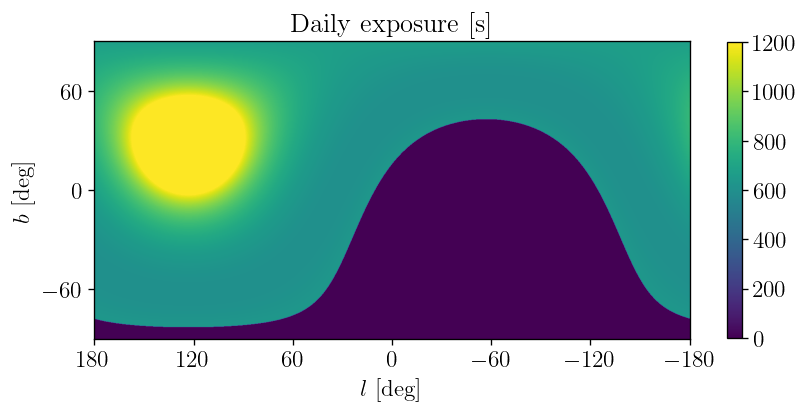

In [23]:
plot_lb(exposure_map, log_norm=False, title='Daily exposure [s]',
        vmax=1200, vmin=0, cmap='viridis')

## 5. S/N

$$S/N = \sqrt{\sum_i (S/N_i)^2}$$

$$S/N_i=\frac{T_{g,i}}{T_{\text{sys},i}}\sqrt{2\Delta\nu~t_\text{obs}}$$

In [24]:
n_day = 3.5 * 365

In [25]:
T_sys_map = 50 + haslam_dsds_map
SNR_g_s = gegen_temp_map * np.sqrt(2*dnu(408)*1e6*exposure_map*n_day) / T_sys_map
SNR_f_s = forward_temp_map * np.sqrt(2*dnu(408)*1e6*exposure_map*n_day) / T_sys_map
print('naive gegenschein:', np.sqrt(np.sum(SNR_g_s**2)))
print('reference forwardschein:', np.sqrt(np.sum(SNR_f_s**2)))

naive gegenschein: 1.870438
reference forwardschein: 1.2446418


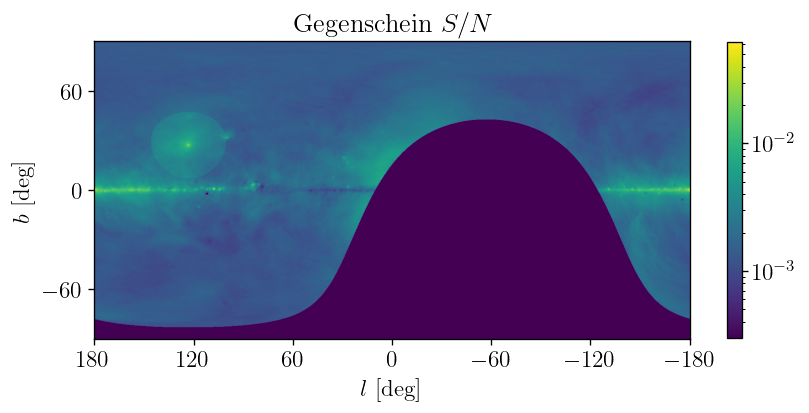

In [27]:
plot_lb(np.clip(SNR_g_s, 3e-4, None), title=r'Gegenschein $S/N$', cmap='viridis')

## 6. Modification according to 3D model

In [66]:
B_scheme = 'BS_H'

I_data = pickle.load(open(f'../data/galactic_models/I_data_{B_scheme}.dict', 'rb'))

In [67]:
g_ratio_lr = I_data['focused'] / I_data['naive']
f_ratio_lr = (I_data['front'] + I_data['forward']) / I_data['forward_ref']

g_ratio = padded_interpolator(I_data['l'], I_data['b'], g_ratio_lr)(l_s, b_s)
f_ratio = padded_interpolator(I_data['l'], I_data['b'], f_ratio_lr)(l_s, b_s)

tot_temp_map = gegen_temp_map * g_ratio + forward_temp_map * f_ratio
SNR_tot_map = tot_temp_map * np.sqrt(2*dnu(408)*1e6*exposure_map*n_day) / T_sys_map
print(f'{B_scheme} SNR = {np.sqrt(np.sum((SNR_tot_map)**2))}')

BS_H SNR = 3.439507484436035


In [68]:
np.save(f'{INTM_DIR}/tot_temp_map_{B_scheme}.npy', tot_temp_map)

## 6. Frequency dependence

In [24]:
tot_temp_map_AR = np.load('../data/tot_temp_map_AR.npy')
tot_temp_map_BS = np.load('../data/tot_temp_map_BS.npy')
dsds_map_downsample = np.load('../data/dsds_map_downsample.npy')
exposure_G = np.load('../data/exposure_G.npy')

In [25]:
freq_s = np.linspace(400, 800, 30)
tot_SNR_s_AR = np.zeros_like(freq_s)
tot_SNR_s_BS = np.zeros_like(freq_s)
beta = -2.55

for i, freq in enumerate(tqdm(freq_s)):
    sig_temp_map = tot_temp_map_AR * (freq/408)**(beta-1)
    bkg_temp_map = 50 + dsds_map_downsample * (freq/408)**(beta)
    SNR_map = sig_temp_map * np.sqrt(2*Dnu*(freq/408)*1e6*exposure_G*3.5*365.25) / bkg_temp_map
    tot_SNR_s_AR[i] = np.sqrt(np.sum(SNR_map**2))
    
    sig_temp_map = tot_temp_map_BS * (freq/408)**(beta-1)
    bkg_temp_map = 50 + dsds_map_downsample * (freq/408)**(beta)
    SNR_map = sig_temp_map * np.sqrt(2*Dnu*(freq/408)*1e6*exposure_G*3.5*365.25) / bkg_temp_map
    tot_SNR_s_BS[i] = np.sqrt(np.sum(SNR_map**2))

  0%|          | 0/30 [00:00<?, ?it/s]

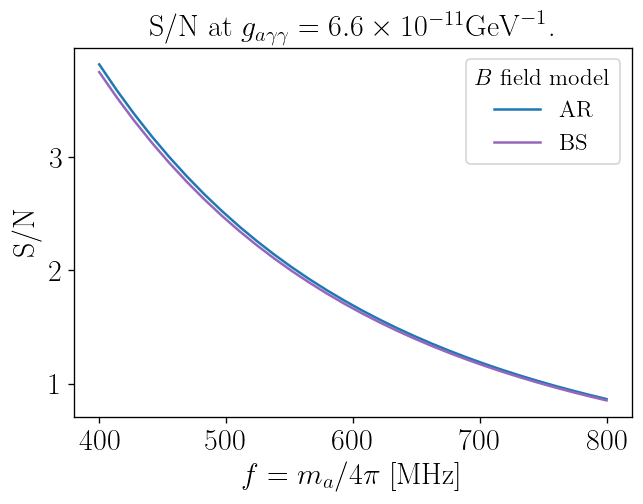

In [35]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(freq_s, tot_SNR_s_AR, label='AR', c='tab:blue')
ax.plot(freq_s, tot_SNR_s_BS, label='BS', c='tab:purple')
ax.set(xlabel=r'$f=m_a/4\pi$ [MHz]', ylabel='S/N',
       title=r'S/N at $g_{a\gamma\gamma}=6.6\times10^{-11}\mathrm{GeV}^{-1}$.')
ax.legend(title=r'$B$ field model');